In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np


class Bandit(object):
    def __init__(self, n_arms, initial_mu=None, arms_sigma=1):
        
        # if not specified, each arm is a gaussian with mean randomly sampled from ~N(0, 1)
        self.bandits_mu = initial_mu if initial_mu is not None else stats.norm(0, 1).rvs(n_arms)
        
        self.sigma = arms_sigma
        
        # remembers the best arm and its reward
        self.best_arm = np.argmax(self.bandits_mu)
        self.best_reward = np.max(self.bandits_mu)
        
        # instantiate the gaussian arms with predefined mu
        self.arms = [stats.norm(mu, arms_sigma) for mu in self.bandits_mu]
        
    def play(self, arm):
        """
        Returns the reward of playing a given arm
        """
        return np.random.normal(self.bandits_mu[arm], self.sigma)
    
    def __str__(self):
        return 'MAB(%d)' % len(self.arms)


In [2]:
import numpy as np
import os
import sys


class Experiment(object):
    def __init__(self, env, agent):
        np.random.seed()
        self.env = env
        self.agent = agent
        self.actions = []
        self.rewards = []
        self.cumulative_reward = 0
        self.cumulative_regret = 0      # actual cumulative regret
        self.cumulative_regret_exp = 0  # expected cumulative regret
        self.freq_best_action = 0       # no. of times the agent select the best arm
        self.trials = 0
        
    def run(self, trials, verbose=False):
        times_best_action = 0
        self.trials = trials
        
        for i in range(trials):
            
            # retrieves an action, makes the player learn and store stats
            action = self.agent.act()
            self.actions.append(action)

            reward = self.env.play(action)
            self.agent.learn(action, reward)
            
            # registers statistics
            self.rewards.append(reward)
            self.cumulative_reward += reward
            self.cumulative_regret += self.env.best_reward - reward
            self.cumulative_regret_exp += self.env.best_reward - self.env.bandits_mu[action]
            
            if action == self.env.best_arm:
                times_best_action += 1
                
            if verbose:
                sys.stdout.write("\rTrial %8d" % i)
                sys.stdout.flush()
                
            #print('%d, %d, %f' % (i, action, reward))
                
        self.freq_best_action = times_best_action / trials
        
    def __str__(self):
        return "%s in %s in %d trials" % (self.agent, self.env, self.trials)



In [3]:
from multiprocessing import Pool
import copy
import os

os.system("taskset -p 0xfffff %d" % os.getpid())

class ParallelExperiment(object):
    """
    Runs experiments in parallel
    """
    def __init__(self, experiments):
        self.experiments = experiments
        self.result = None
        
    def run(self, trials, verbose=False):
        self.trials = trials
        self.verbose = verbose
        num_pool = max(10, len(self.experiments))
        
        with Pool(num_pool) as p:
            self.result = p.map(self.run_binded, self.experiments)
            
    def run_binded(self, experiment):
        experiment.run(self.trials, self.verbose)
        return copy.copy(experiment)

# uncomment to test
"""
b = Bandit(100)
a = PruningAgentFair(b)
reps = ParallelExperiment([Experiment(b, PruningAgentFair(b)) for _ in range(10)])
reps.run(10000, verbose=False)
#print([sum(r.rewards) for r in reps.result])
#print([r.cumulative_reward for r in reps.result])
avg_rwd = np.average([r.rewards for r in reps.result], axis=0)
plt.plot(np.convolve(avg_rwd, np.ones((100,))/100, mode='valid')) #running average: https://stackoverflow.com/a/22621523)
plt.show()
"""
pass

In [4]:
def meeting_point(a, b, window=100, start=0):
    """
    Determines the point where the moving average of a meets that of b 
    
    """
    cva = np.convolve(a, np.ones((window,))/window, mode='valid')
    cvb = np.convolve(b, np.ones((window,))/window, mode='valid')
    
    for x, (val_a, val_b) in enumerate(zip(cva, cvb)):
        
        if x > start and val_a > val_b:
            return x
    return -1

In [5]:
#FIXME:  better use ParallelExperiment directly!

class RepeatedExperiment(object):
    def __init__(self, env, agent, repetitions=5):
        self.experiments = [Experiment(env, agent) for _ in range(repetitions)]
        self.parallel = ParallelExperiment(self.experiments)
        
    def run(self, trials):
        self.parallel.run(trials)
        self.result = self.parallel.result

"""
b = Bandit(100)
a = PruningAgentFair(b)
reps = RepeatedExperiment(b, a, 5)
reps.run(10000)
print([sum(r.rewards) for r in reps.result])
print([r.cumulative_reward for r in reps.result])
avg_rwd = np.average([r.rewards for r in reps.result], axis=0)
plt.plot(np.convolve(avg_rwd, np.ones((100,))/100, mode='valid')) #running average: https://stackoverflow.com/a/22621523)
plt.show()
"""
pass

In [6]:
import scipy.stats as stats
import numpy as np

class UniformAgent(object):
    def __init__(self, bandit):
        self.bandit = bandit
        
        # assigns uniformly random probs. to arms, then normalize
        self.probabilities = stats.uniform(0, 1).rvs(len(bandit.arms))
        
        sum_probs = sum(self.probabilities)
        
        # normalizes
        self.probabilities = [p / sum_probs for p in self.probabilities]
        
        #checks
        assert np.isclose(1, sum(self.probabilities))
        
        #saves cumulative probabilities:
        self.cumprobs = np.cumsum(self.probabilities)
        
    def act(self):
        """
        Selects an arm in proportion with the probabilities
        """
        # code copied from OpenAI Gym gym/envs/toy_text/discrete.py
        return (self.cumprobs > np.random.rand()).argmax()
        
    def argmax(self):
        """
        Returns the arm with highest probability
        """
        return np.argmax(self.probabilities)
    
    def epsilon_argmax(self, epsilon):
        if np.random.random() < epsilon:
            return np.random.randint(0, len(self.probabilities))  
        return self.greedy()
    
    def learn(self, *args):
        pass
    
    def __str__(self):
        return "UniformAgent"

# uncomment to test uniform agent
"""
b = bandit.Bandit(10)
a = agent.UniformAgent(b)
print(a.argmax())
plt.hist([a.act() for _ in range(10000)])
plt.show()
"""
pass #prevents outputting the comment string

In [7]:

class UniformBiasedAgent(UniformAgent):
    def __init__(self, bandit):
        self.bandit = bandit
        
        # samples the prob of choosing the best arm from [0, 1]
        p_best = stats.uniform(0, 1).rvs(1)[0]
        
        # samples the prob of choosing the other arms from [0, 1-p_best]
        p_others = stats.uniform(0, 1 - p_best).rvs(len(bandit.arms) -1)  
               
        # normalizes
        sum_others = sum(p_others)
        #norm_factor = sum_others*(1 - p_best)
        p_others = [p *(1 - p_best) / sum_others for p in p_others]
        
        #print(p_best, sum_others, sum(p_others))
        
        # finally assigns the probabilities
        offset = 0 # helps on getting the prob. from correct position
        self.probabilities = np.zeros(len(bandit.arms))
        for i, arm in enumerate(bandit.arms):
            if i == bandit.best_arm:
                self.probabilities[i] = p_best
                offset = 1 # to discount that I'm not getting p_others[i] in this iteration
            else:
                self.probabilities[i] = p_others[i - offset]
        
        #checks
        assert np.isclose(1, sum(self.probabilities))
        
        #saves cumulative probabilities:
        self.cumprobs = np.cumsum(self.probabilities)
    
    def __str__(self):
        return "UniformBiasedAgent"


# uncomment to test uniform biased agent
"""
b = Bandit(10)
a = UniformBiasedAgent(b)
print(a.argmax())
plt.hist([a.act() for _ in range(10000)])
plt.show()
"""
pass # prevents outputting a comment string

In [8]:
class GaussianBiasedAgent(UniformAgent):
    def __init__(self, bandit, mu=.5, sigma=.2):
        self.bandit = bandit
        
        # samples the prob of choosing the best arm from N(mu, sigma) - ensuring it is in [0, 1]
        p_best = stats.norm(mu, sigma).rvs(1)[0]
        p_best = min(1, max(0, p_best))
        
        
        # samples the prob of choosing the other arms from [0, 1-p_best]
        p_others = stats.uniform(0, 1 - p_best).rvs(len(bandit.arms) -1)
               
        # normalizes (if needed)
        if not np.isclose(p_best, 1):
            sum_others = sum(p_others)
            #norm_factor = sum_others*(1 - p_best)
            p_others = [p *(1 - p_best) / sum_others for p in p_others]

        #print(p_best, sum_others, sum(p_others))
        
        # finally assigns the probabilities
        offset = 0 # helps on getting the prob. from correct position
        self.probabilities = np.zeros(len(bandit.arms))
        for i, arm in enumerate(bandit.arms):
            if i == bandit.best_arm:
                self.probabilities[i] = p_best
                offset = 1 # to discount that I'm not getting p_others[i] in this iteration
            else:
                self.probabilities[i] = p_others[i - offset]
        
        #checks
        #print(p_best, sum(self.probabilities))
        assert np.isclose(1, sum(self.probabilities))
        
        #saves cumulative probabilities:
        self.cumprobs = np.cumsum(self.probabilities)

        
    def __str__(self):
        return "GaussianAgent"
    
# uncomment to test
"""
b = Bandit(10)
for i in range(1000):
    a = GaussianBiasedAgent(b)
#print(a.argmax())
#plt.hist([a.act() for _ in range(10000)])
#plt.show()
"""
pass # prevents outputting a comment string

In [9]:
from math import ceil

class PruningAgentWeak(UniformAgent):
    """
    Only a few actions have nonzero probability, the best action may have zero probability
    """
    def __init__(self, bandit, prune_factor=0.8):
        self.bandit = bandit
        
        n_arms = len(self.bandit.arms)
        num_nonzero = ceil(n_arms * (1 - prune_factor))
        
        # at least 2 actions should have non-zero probability
        if num_nonzero < 2:
            num_nonzero = 2
        
        # determines which actions will have non-zero probability
        which_nonzero = np.random.choice(range(n_arms), num_nonzero, replace=False)

        # samples the prob of choosing arms from U[0, 1]
        probs = stats.uniform(0, 1).rvs(num_nonzero)  
               
        # normalizes
        sum_probs = sum(probs)
        probs = [p / sum_probs for p in probs]
        
        # determines probabilities of actions
        self.probabilities = np.zeros(len(bandit.arms))
        for which, prob in zip(which_nonzero, probs):
            self.probabilities[which] = prob
                
        #checks
        assert np.isclose(1, sum(self.probabilities))
        
        #saves cumulative probabilities:
        self.cumprobs = np.cumsum(self.probabilities)
        
    def __str__(self):
        return "PruningAgentWeak"

# uncomment to test pruning agent
"""
b = Bandit(10)
a = PruningAgentWeak(b, .8)
print('b-best, a-best = %d, %d' % (b.best_arm, a.argmax()))
plt.hist([a.act() for _ in range(10000)])
plt.show()
"""
pass # prevents outputting a comment string

In [10]:
class PruningAgentStrong(PruningAgentWeak):
    """
    Only a few actions have nonzero probability, the best action (a*) DOES NOT have zero probability
    In fact, it is very likely that p_a* > p_a' for all a' != a*
    """
    def __init__(self, bandit, prune_factor=0.8, p_best_generator = None):
        self.bandit = bandit
        
        if p_best_generator is None:
            p_best_generator = stats.uniform(0, 1)
        
        n_arms = len(self.bandit.arms)
        num_nonzero = ceil(n_arms * (1 - prune_factor))
        
        # at least 2 actions should have non-zero probability
        if num_nonzero < 2:
            num_nonzero = 2
        
        # determines which actions will have non-zero probability
        which_nonzero = np.random.choice(range(n_arms), num_nonzero, replace=False)

        if bandit.best_arm not in which_nonzero:
            # replaces the first occurrence with the best
            which_nonzero[0] = bandit.best_arm
        else:
            # puts best in first position by swapping
            where = np.where(which_nonzero == bandit.best_arm) # which_nonzero.index(bandit.best_arm)
            which_nonzero[0], which_nonzero[where] =  which_nonzero[where], which_nonzero[0]
            
        # samples the prob of choosing the best arm from U[0, 1]
        # p_best > all other with high probability
        p_best = 0 
        while p_best <= 1.0 / num_nonzero:
            p_best = p_best_generator.rvs(1)[0]
            
        # ensures p_best <= 1
        p_best = min(1, p_best)
        
        # samples the prob of choosing the other arms from U[0, 1-p_best]
        p_others = stats.uniform(0, 1 - p_best).rvs(num_nonzero -1) 
               
        # normalizes
        sum_others = sum(p_others)
        p_others = [p *(1 - p_best) / sum_others for p in p_others]
        
        # if p_best is 1, p_others is zeros
        if np.isclose(p_best, 1):
            p_others = [0] * (num_nonzero - 1)
        
        
        # construct a vector with all probabilities (best in first position)
        p_all = [p_best] + p_others
        
        #print(len(which_nonzero), len(p_all), num_nonzero)
        
        # determines which actions will have nonzero probability
        self.probabilities = np.zeros(len(bandit.arms))
        for which, prob in zip(which_nonzero, p_all):
            self.probabilities[which] = prob
                
        #checks
        #print(p_best, sum(self.probabilities))
        assert np.isclose(1, sum(self.probabilities))
        
        #saves cumulative probabilities:
        self.cumprobs = np.cumsum(self.probabilities)

    def __str__(self):
        return "PruningAgentStrong"
    
# uncomment to test
"""
b = Bandit(100)
for _ in range(1000):
    a = PruningAgentStrong(b, .8, stats.norm(.5, .2))
    #a = PruningAgentStrong(b, .8)
    #print('b-best, a-best = %d, %d' % (b.best_arm, a.argmax()))
plt.hist([a.act() for _ in range(10000)])
plt.show()
"""
pass # prevents outputting a comment string

In [11]:
class PruningAgentFair(PruningAgentWeak):
    """
    Only a few actions have nonzero probability, the best action (a*) DOES NOT have zero probability
    It is drawn from a uniform probability, just like the others :) 
    """
    def __init__(self, bandit, prune_factor=0.8, p_best_generator = None):
        self.bandit = bandit
        
        n_arms = len(self.bandit.arms)
        num_nonzero = ceil(n_arms * (1 - prune_factor))
        
        # at least 2 actions should have non-zero probability
        if num_nonzero < 2:
            num_nonzero = 2
        
        # determines which actions will have non-zero probability
        which_nonzero = np.random.choice(range(n_arms), num_nonzero, replace=False)

        # ensures the best arm is among non_zero
        if bandit.best_arm not in which_nonzero:
            # replaces the first occurrence with the best
            which_nonzero[0] = bandit.best_arm
        else:
            # puts best in first position by swapping
            where = np.where(which_nonzero == bandit.best_arm) # which_nonzero.index(bandit.best_arm)
            which_nonzero[0], which_nonzero[where] =  which_nonzero[where], which_nonzero[0]
            
        # samples the prob of choosing arms from U[0, 1]
        probs = stats.uniform(0, 1).rvs(num_nonzero)  
               
        # normalizes
        sum_probs = sum(probs)
        probs = [p / sum_probs for p in probs]
        
        # determines probabilities of actions
        self.probabilities = np.zeros(len(bandit.arms))
        for which, prob in zip(which_nonzero, probs):
            self.probabilities[which] = prob
        
        #checks
        assert np.isclose(1, sum(self.probabilities))
        assert self.probabilities[bandit.best_arm] > 0
        
        #saves cumulative probabilities:
        self.cumprobs = np.cumsum(self.probabilities)
        
    def __str__(self):
        return "PruningAgentFair"

# uncomment to test pruning agent
"""
for _ in range(1000):
    b = Bandit(100)
    a = PruningAgentFair(b, .8)
print('b-best, a-best = %d, %d' % (b.best_arm, a.argmax()))
plt.hist([a.act() for _ in range(10000)])
plt.show()
"""
pass # prevents outputting a comment string

In [12]:
class LearningAgent(object):
    def __init__(self, bandit, alpha=0.1):
        self.bandit = bandit
        self.alpha = alpha
        self.q = np.zeros(len(bandit.arms))
        self.last_choice = None
        
    def act(self, epsilon=0.1):
        """
        Epsilon greedy over actions
        TODO: break ties arbitrarily in np.argmax
        """
        if np.random.random() < epsilon:
            self.last_choice =  np.random.randint(0, len(self.q))  
        else:
            self.last_choice = np.random.choice(np.flatnonzero(self.q == self.q.max())) #np.argmax(self.q)
            #np.argmax(self.q)
        
        return self.last_choice
    
    def learn(self, choice, reward):
        """
        Q-learning update rule (without states for now)
        """
        self.q[choice] = self.q[choice] + self.alpha*(reward - self.q[choice])
        
    def __str__(self):
        return "LearningAgent"
        
# uncomment to test
"""
trials = 100000
env = Bandit(100, arms_sigma=0)
learner = LearningAgent(env)

exp = Experiment(env, learner)
exp.run(trials)
    
#stats:
freq_best = sum([1 for x in exp.actions if x == env.best_arm])

print("% best:", freq_best / trials)
#plt.hist(actions)
#plt.hist(rewards)
#running average: https://stackoverflow.com/a/22621523
plt.plot(np.convolve(exp.rewards, np.ones((100,))/100, mode='valid')) 
plt.show()
"""
pass

In [13]:
class Controller(object):
    def __init__(self, team, alpha=0.1, name='Controller'):
        """
        Receives the array of agents
        """
        self.team = team
        self.q = [0 for _ in self.team]
        self.last_choice = None
        self.last_agent_index = None
        self.alpha = alpha
        self.name = name
        
    def act(self, epsilon=0.1):
        """
        Epsilon greedy over agents
        # TODO: break ties randomly in argmax
        """
        
        if np.random.random() < epsilon:
            self.last_agent_index =  np.random.randint(0, len(self.q))  
        else:
            self.last_agent_index = np.argmax(self.q)
        
        self.last_choice = self.team[self.last_agent_index].act()
        
        return self.last_choice
    
    def learn(self, choice, reward):
        """
        Q-learning update rule (without states for now)
        """
        a = self.last_agent_index
        self.q[a] = self.q[a] + self.alpha*(reward - self.q[a])
        
    def __str__(self):
        return self.name

# uncomment to test
"""
trials = 10000
env = Bandit(100, arms_sigma=0)
weak = Controller([PruningAgentWeak(env) for _ in range(10)])
fair = Controller([PruningAgentFair(env) for _ in range(10)])
strong = Controller([PruningAgentStrong(env) for _ in range(10)])
mixed = Controller([PruningAgentWeak(env) for _ in range(9)] + [PruningAgentStrong(env)])  # 9 weak + 1 strong

controllers = {'weak': weak, 'fair': fair, 'strong': strong, 'mixed': mixed}

for name, ctrl in controllers.items():
    exp = Experiment(env, ctrl)
    exp.run(trials)

    #stats:
    freq_best = sum([1 for x in exp.actions if x == env.best_arm])

    print("%s: freq. best: %f, acc. rwd: %d" % (name, freq_best / trials, exp.cumulative_reward) )
    #plt.hist(actions)
    #plt.hist(rewards)
    plt.plot(np.convolve(exp.rewards, np.ones((100,))/100, mode='valid')) #running average: https://stackoverflow.com/a/22621523

    plt.legend(controllers.keys())
plt.show()
"""
pass

In [ ]:
# The real test

team_sizes = [5, 10, 50, 100, 500]     
bandit_sizes = [100, 1000]
trials = 10000

for n_arms in bandit_sizes:
    bandit = Bandit(n_arms)
    
    learner = LearningAgent(bandit)
    over_actions = Experiment(bandit, learner)
    over_actions.run(trials)
    
    for team_sz in team_sizes:
        ctrl_unif = Controller([UniformAgent(bandit) for _ in range(team_sz)])
        ctrl_ubias = Controller([UniformBiasedAgent(bandit) for _ in range(team_sz)])
        ctrl_prun = Controller([PruningAgentFair(bandit) for _ in range(team_sz)])
        ctrl_gauss = Controller([GaussianBiasedAgent(bandit) for _ in range(team_sz)])
        
        #over_unif_agents = Experiment(bandit, ctrl_unif)
        #over_unif_agents.run(trials)
        
        over_gauss_agents = Experiment(bandit, ctrl_gauss)
        over_gauss_agents.run(trials)
        
        over_biased_agents = Experiment(bandit, ctrl_ubias)
        over_biased_agents.run(trials)
        
        over_pruning_agents = Experiment(bandit, ctrl_prun)
        over_pruning_agents.run(trials)
        
        # plots rewards over time
        #running average from https://stackoverflow.com/a/22621523
        plt.plot(np.convolve(over_actions.rewards, np.ones((100,))/100, mode='valid'), label='Actions') 
        plt.plot(np.convolve(over_gauss_agents.rewards, np.ones((100,))/100, mode='valid'), label='GaussAgt') 
        plt.plot(np.convolve(over_biased_agents.rewards, np.ones((100,))/100, mode='valid'), label='BiasAgt') 
        plt.plot(np.convolve(over_pruning_agents.rewards, np.ones((100,))/100, mode='valid'), label='PrunAgt') 
        plt.legend([
            'Actions', 
            'GaussAgents', 
            'BiasedAgents', 
            'PruningAgents'
        ])
        plt.title("#actions: %d - team_size: %d"  % (n_arms, team_sz))
        plt.show()
        
        # plots freq. of best actions
        d = {
            'Actions': over_actions.freq_best_action, 
            'GaussAgt': over_gauss_agents.freq_best_action,
            'BiasAgt': over_biased_agents.freq_best_action,
            'PrunAgt': over_pruning_agents.freq_best_action,
        }

        plt.title("Freq. of best action, for #actions: %d - team_size: %d"  % (n_arms, team_sz))
        plt.bar(range(len(d)), d.values(), align='center')
        plt.xticks(range(len(d)), d.keys(), rotation='vertical')
        #plt.plot()
        
        plt.show()

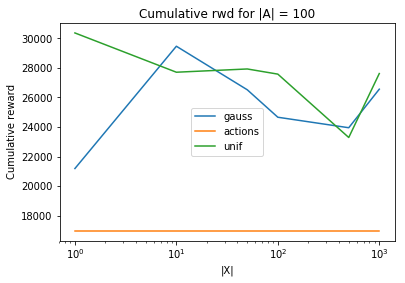

In [83]:
# test over team size
import sys

n_arms = 100
trials = 10000
bandit = Bandit(n_arms, arms_sigma=0) # deterministic bandit

x_values = []

max_expected_rwd = np.max(bandit.bandits_mu) * trials
#print(max_expected_rwd, bandit.arms[bandit.best_arm].expect())

learner = LearningAgent(bandit)
over_actions = Experiment(bandit, learner)
over_actions.run(trials)

rwd_actions = sum(over_actions.rewards)
regret_actions = max_expected_rwd - rwd_actions

team_sizes = [1, 10, 50, 100, 500, 1000]

experiments = []
for team_sz in team_sizes:
    #sys.stdout.write("\r|X| = %6d" % team_sz)
    
    x_values.append(team_sz)
    
    #ctrl_unif = Controller([UniformAgent(bandit) for _ in range(team_sz)])
    ctrl_ubias = Controller([UniformBiasedAgent(bandit) for _ in range(team_sz)], name='Uniform')
    #ctrl_prun = Controller([PruningAgentFair(bandit) for _ in range(team_sz)])
    ctrl_gauss = Controller([GaussianBiasedAgent(bandit) for _ in range(team_sz)], name='Gaussian')
    
    experiments += [Experiment(bandit, ctrl_ubias), Experiment(bandit, ctrl_gauss)]

manager = ParallelExperiment(experiments)
manager.run(trials)

results = {
    'gauss': [r for r in manager.result if str(r.agent) == 'Gaussian'],
    'unif': [r for r in manager.result if str(r.agent) == 'Uniform'],
    'actions': [over_actions] * len(team_sizes)
}


#regrets['actions'] = np.ones(len(x_values)) * regret_actions
for name, result in results.items():
    y_values = [exp.cumulative_reward for exp in result]
    #x_values = [len(exp.agent.team) for exp in result] if name != 'actions' else team_sizes
    x_values = team_sizes 
    plt.plot(x_values, y_values) # let's hope that x and y are aligned
    
#plt.plot(x_values, len(x_values) * rwd_actions)

plt.xlabel("|X|")
plt.ylabel("Cumulative reward")
plt.legend(results.keys())
plt.title("Cumulative rwd for |A| = %d in %d trials" % (n_arms, trials))
plt.xscale('log')
plt.show()



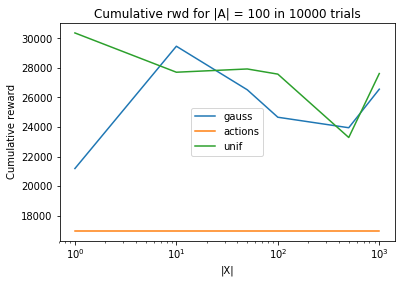

{'gauss': [7544, 7793, 974, 7595, 7580, 7580], 'unif': [8586, 7594, 8551, 7793, 880, 7595]}


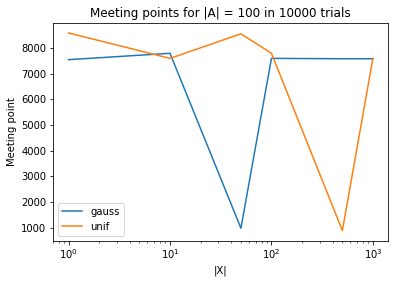

In [84]:
# playing with results of previous box
meeting_points = {}
for name, result in results.items():
    y_values = [exp.cumulative_reward for exp in result]
    #x_values = [len(exp.agent.team) for exp in result] if name != 'actions' else team_sizes
    x_values = team_sizes 
    
    plt.plot(x_values, y_values) # let's hope that x and y are aligned
    #a2.plot(x_values, meeting_points[name])
    
#plt.plot(x_values, len(x_values) * rwd_actions)

plt.xlabel("|X|")
plt.ylabel("Cumulative reward")
plt.legend(results.keys())
plt.title("Cumulative rwd for |A| = %d in %d trials" % (n_arms, trials))
plt.xscale('log')
plt.show()

for name, result in results.items():
    y_values = [exp.cumulative_reward for exp in result]
    #x_values = [len(exp.agent.team) for exp in result] if name != 'actions' else team_sizes
    x_values = team_sizes 
    
    if name != 'actions':
        meeting_points[name] = [meeting_point(over_actions.rewards, e.rewards) for e in result]
        plt.plot(x_values, meeting_points[name]) # let's hope that x and y are aligned
    #a2.plot(x_values, meeting_points[name])
    
print(meeting_points)
plt.xlabel("|X|")
plt.ylabel("Meeting point")
plt.legend(meeting_points.keys())
plt.title("Meeting points for |A| = %d in %d trials" % (n_arms, trials))
plt.xscale('log')
plt.show()


In [118]:
# test of the gaussian agent 

mus = [0.1] #, 0.5, 0.9] #np.arange(.1, 1, .1) #0.1, ... 0.9
sigmas = [0.1, 0.5] #np.arange(0.1, 0.6, 0.1) #0.1, ..., 0.5
team_sizes = [10, 100, 1000]
n_arms = 500
trials = 10000
repetitions = 5

experiments = []
print("Setup")

env = Bandit(n_arms, arms_sigma=0)  # deterministic bandit

for size in team_sizes:
    for mu in mus:
        for sigma in sigmas:
            for r in range(repetitions):
                controller = Controller(
                    [GaussianBiasedAgent(env, mu, sigma) for _ in range(size)], 
                    name='G(%.3f, %.3f)' % (mu, sigma)
                )
                experiments.append(Experiment(env, controller))
            
print("Action!")
manager = ParallelExperiment(experiments)
manager.run(trials)

la = LearningAgent(env)
la_experiment = Experiment(env, la)
la_experiment.run(trials)
print("Done")


Setup
Action!
Done


In [144]:
# play with the results of the experiment above
def exp_id(exp):
    return "%s %5d" % (exp.agent, len(exp.agent.team))


# group repeated experiments
groups = {exp_id(exp): [] for exp in manager.result}

for exp in manager.result:
    #print("%s %5d: %6d" % (exp.agent, len(exp.agent.team), meeting_point(la_experiment.rewards, exp.rewards, start=100)))
    groups.get(exp_id(exp), []).append(exp.rewards)

# counts number of not-meeting in each group
divergences = {}
for name, rwds in groups.items():
    #print(len(rwds))
    divergences[name] = sum([1 for x in rwds if meeting_point(la_experiment.rewards, x, start=100) == -1])

sorted_keys = sorted(divergences.keys())
    
print("Name\t\t\t#divergences")
for k in sorted_keys:
    print("%s:\t%d" % (k, divergences[k]))
    
# save
for name, g in groups.items():
    for index, rep in enumerate(g):
        np.savez_compressed('%s_%d' % (name, index), rep)

    #np.savez_compressed('%s_x%d' % (exp.agent, len(exp.agent.team)), exp.rewards)
#np.savez_compressed('la-vs-gaussian', la_experiment.rewards)

Name			#divergences
G(0.100, 0.100)    10:	0
G(0.100, 0.100)   100:	0
G(0.100, 0.100)  1000:	0
G(0.100, 0.500)    10:	2
G(0.100, 0.500)   100:	4
G(0.100, 0.500)  1000:	3


In [168]:
# test of team with a single gaussian agent, the remaining teammates are weak agents

mus = [0.1, 0.5, 0.9] #np.arange(.1, 1, .1) #0.1, ... 0.9
sigmas = [0] #[0.1, 0.5] #np.arange(0.1, 0.6, 0.1) #0.1, ..., 0.5
team_sizes = [10, 100, 1000]
n_arms = 500
trials = 10000
repetitions = 1

experiments = []
print("Setup")

env = Bandit(n_arms, arms_sigma=0)  # deterministic bandit

for size in team_sizes:
    for mu in mus:
        for sigma in sigmas:
            for r in range(repetitions):
                controller = Controller(
                    [UniformAgent(env) for _ in range(size)] + [GaussianBiasedAgent(env, mu, sigma)], 
                    name='G(%.3f, %.3f)' % (mu, sigma)
                )
                experiments.append(Experiment(env, controller))
            
print("Action!")
manager = ParallelExperiment(experiments)
manager.run(trials)

la = LearningAgent(env)
la_experiment = Experiment(env, la)
la_experiment.run(trials)
print("Done")



Setup
Action!
Done


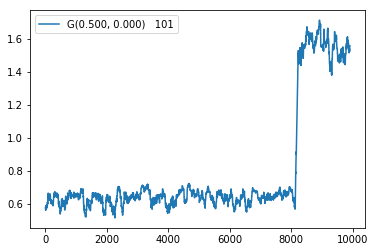

Name			#div	meet
G(0.100, 0.000)    11:	0	101
G(0.100, 0.000)   101:	0	101
G(0.100, 0.000)  1001:	0	101
G(0.500, 0.000)    11:	0	4164
G(0.500, 0.000)   101:	0	101
G(0.500, 0.000)  1001:	0	101
G(0.900, 0.000)    11:	1	-1
G(0.900, 0.000)   101:	0	101
G(0.900, 0.000)  1001:	0	101


In [169]:
# playing with results of the box above

#la = LearningAgent(env)
#la_experiment = Experiment(env, la)
#la_experiment.run(trials)

def exp_id(exp):
    return "%s %5d" % (exp.agent, len(exp.agent.team))


# group repeated experiments
groups = {exp_id(exp): [] for exp in manager.result}

for exp in manager.result:
    #print("%s %5d: %6d" % (exp.agent, len(exp.agent.team), meeting_point(la_experiment.rewards, exp.rewards, start=100)))
    groups.get(exp_id(exp), []).append(exp.rewards)

# counts number of not-meeting in each group
divergences = {}
meetings = {}
for name, rwds in groups.items():
    #print(len(rwds))
    #plt.plot(np.convolve(np.average(rwds, axis=0), np.ones((100,))/100, mode='valid') )
    meetings[name] = np.average([meeting_point(la_experiment.rewards, x, start=100) for x in rwds])
    divergences[name] = sum([1 for x in rwds if meeting_point(la_experiment.rewards, x, start=100) == -1])
             
plt.plot(np.convolve(la_experiment.rewards, np.ones((100,))/100, mode='valid') )
plt.legend(groups.keys())
plt.show()

sorted_keys = sorted(divergences.keys())
#print(meetings)
print("Name\t\t\t#div\tmeet")
for k in sorted_keys:
    print("%s:\t%d\t%d" % (k, divergences[k], meetings[k]))
    
# save
#for name, g in groups.items():
#    for index, rep in enumerate(g):
#        np.savez_compressed('%s_%d' % (name, index), rep)

In [159]:
# test over number of actions
import sys
trials = 10000


team_sizes = [10, 100, 1000]
for team_sz in team_sizes:
    # stores the difference in accumulated reward of each method vs learning over actions
    deltas = {'ubiased': [], 'gauss': [], 'prun':[]}
    rewards = {'actions':[], 'ubiased': [], 'gauss': [], 'prun':[]}
    regrets = {'actions':[], 'ubiased': [], 'gauss': [], 'prun':[]}
    x_values = []
    
    for n_arms in range(10, 500, 10):
        sys.stdout.write("\r|A|, |X| = %6d, %6d" % (n_arms, team_sz))
        bandit = Bandit(n_arms, arms_sigma=0) # deterministic bandit
        learner = LearningAgent(bandit)
        over_actions = Experiment(bandit, learner)
        over_actions.run(trials)

        rwd_actions = sum(over_actions.rewards)

        x_values.append(n_arms)
    
        ctrl_unif = Controller([UniformAgent(bandit) for _ in range(team_sz)])
        ctrl_ubias = Controller([UniformBiasedAgent(bandit) for _ in range(team_sz)])
        ctrl_prun = Controller([PruningAgentFair(bandit) for _ in range(team_sz)])
        ctrl_gauss = Controller([GaussianBiasedAgent(bandit) for _ in range(team_sz)])

        over_gauss_agents = Experiment(bandit, ctrl_gauss)
        over_gauss_agents.run(trials)
        rewards['gauss'].append(over_gauss_agents.cumulative_reward)
        regrets['gauss'].append(over_gauss_agents.cumulative_regret)
        deltas['gauss'].append(over_gauss_agents.cumulative_reward - rwd_actions)

        over_biased_agents = Experiment(bandit, ctrl_ubias)
        over_biased_agents.run(trials)
        rewards['ubiased'].append(over_biased_agents.cumulative_reward)
        regrets['ubiased'].append(over_biased_agents.cumulative_regret)
        deltas['ubiased'].append(over_biased_agents.cumulative_reward - rwd_actions)

        over_pruning_agents = Experiment(bandit, ctrl_prun)
        over_pruning_agents.run(trials)
        rewards['prun'].append(over_pruning_agents.cumulative_reward)
        regrets['prun'].append(over_pruning_agents.cumulative_regret)
        deltas['prun'].append(over_pruning_agents.cumulative_reward - rwd_actions)
        
        rewards['actions'].append(over_actions.cumulative_reward)
        regrets['actions'].append(over_actions.cumulative_regret)

    sys.stdout.write("\r" + ' ' * 70)  #clears up the output
    #print('Plotting:')

    for name, y_values in rewards.items():
        plt.plot(x_values, y_values)

    plt.xlabel("|A|")
    plt.ylabel("Cumulative reward")
    plt.legend(rewards.keys())
    plt.title("Cumulative rwd for |X| = %d" % team_sz)
    plt.show()

pass

|A|, |X| =     60,     10

KeyboardInterrupt: 

In [ ]:
# test of corollary 1
import matplotlib.pyplot as plt
import numpy as np
import os
os.system("taskset -p 0xfffff %d" % os.getpid()) # for multitasking
os.sched_setaffinity(0, {i for i in range(10)})

n_arms = 1000
team_sz = 100
trials = 100000 # 1e6

ax = plt.figure()

experiments = []
print("Setting up")
for repetition in range(5):
    print("band")
    b = Bandit(n_arms, arms_sigma=0)
    print('done')
    a = LearningAgent(b)
    team = [UniformAgent(b) for _ in range(team_sz - 1)] + [PruningAgentStrong(b)]
    ctrl_mixed = Controller(team, name='Mixed')
    
    experiments += [Experiment(b, a), Experiment(b, ctrl_mixed)]

print("Set-up complete")
manager = ParallelExperiment(experiments)
manager.run(trials, verbose=False)

la_rewards = [res.rewards for res in manager.result if str(res.agent) == 'LearningAgent']
mixed_rewards = [res.rewards for res in manager.result if str(res.agent) == 'Mixed']

la_rewards = np.average(la_rewards, axis=0)
mixed_rewards = np.average(mixed_rewards, axis=0)
#print(len(la_rewards), la_rewards.shape)
#print(len(mixed_rewards), mixed_rewards.shape)


plt.plot(np.convolve(la_rewards, np.ones((100,))/100, mode='valid'), label='Actions') 
plt.plot(np.convolve(mixed_rewards, np.ones((100,))/100, mode='valid'), label='GaussAgt')
plt.legend(['Actions', 'Agents'])
plt.title("|X| = %d, |A| = %d" % (team_sz, n_arms))
plt.xlabel('Trials')
plt.ylabel('Reward')
plt.show()

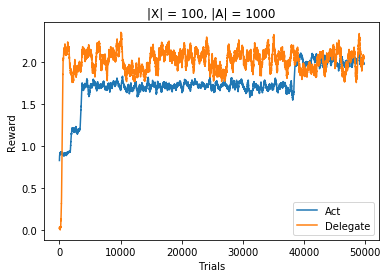

In [63]:
# here we can play with the results of the previous box
np.savez_compressed('act_1k_100k-x100', la_rewards)
np.savez_compressed('del_1k_100k-x100', la_rewards)

# plotting from trial 0 t0 50k
cropped_la = la_rewards[:50000]
cropped_mx = mixed_rewards[:50000]
window = 250

plt.plot(np.convolve(cropped_la, np.ones((window,))/window, mode='valid'), label='Actions') 
plt.plot(np.convolve(cropped_mx, np.ones((window,))/window, mode='valid'), label='GaussAgt')
plt.legend(['Act', 'Delegate'])
plt.title("|X| = %d, |A| = %d" % (team_sz, n_arms))
plt.xlabel('Trials')
plt.ylabel('Reward')
plt.show()

Setup
Action!


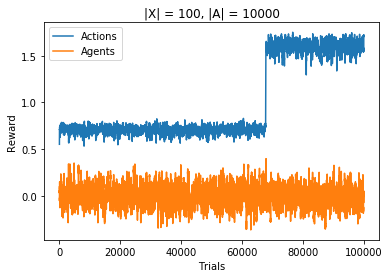

In [15]:
# Test pruning agent in large |A| +- similar to test of Corollary 1
import matplotlib.pyplot as plt
import numpy as np
import os
os.system("taskset -p 0xfffff %d" % os.getpid()) # for multitasking
os.sched_setaffinity(0, {i for i in range(10)})

n_arms = 10000
team_sz = 100
trials = 100000 

ax = plt.figure()

experiments = []
print("Setup")
for repetition in range(1):
    b = Bandit(n_arms, arms_sigma=0)
    a = LearningAgent(b)
    team = [PruningAgentFair(b, prune_factor=10/n_arms) for _ in range(team_sz)] #10 non-zero-prob actions
    ctrl_mixed = Controller(team, name='PruningFair')
    
    experiments += [Experiment(b, a), Experiment(b, ctrl_mixed)]

print("Action!")
manager = ParallelExperiment(experiments)
manager.run(trials, verbose=False)

la_rewards = [res.rewards for res in manager.result if str(res.agent) == 'LearningAgent']
mixed_rewards = [res.rewards for res in manager.result if str(res.agent) == 'PruningFair']

la_rewards = np.average(la_rewards, axis=0)
mixed_rewards = np.average(mixed_rewards, axis=0)
#print(len(la_rewards), la_rewards.shape)
#print(len(mixed_rewards), mixed_rewards.shape)


plt.plot(np.convolve(la_rewards, np.ones((100,))/100, mode='valid'), label='Actions') 
plt.plot(np.convolve(mixed_rewards, np.ones((100,))/100, mode='valid'), label='PruningFair')
plt.legend(['Actions', 'Agents'])
plt.title("|X| = %d, |A| = %d" % (team_sz, n_arms))
plt.xlabel('Trials')
plt.ylabel('Reward')
plt.show()